<a href="https://colab.research.google.com/github/GabrielFCosta/TCC-BSI-2023.1/blob/main/old/matc97_gabriel_teste_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import math
import nltk
import random
import pandas as pd
import numpy as np
import time as tm
import matplotlib.pyplot as plt
import statistics as stats
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Função de tokenização e POS tagging recebe string 
# retorna lista de tuplas contendo palavras e respectivas classes gramaticais
def postagtokenize(text):
  return pos_tag(word_tokenize(text))

# Retorna dataframe de palavras e frequências
# recebe lista de dados (words) e nome da coluna (colname)
def returndataset(words,colname):
  # junta listas de palavras e rótulos num dataframe
  dataset = pd.DataFrame(zip(words),columns =[colname])
  # calcula frequências das palavras e adiciona nova coluna 'freq'
  dataset['freq'] = dataset.groupby([colname])[colname].transform('count')
  return dataclean(dataset)
 
# Remove linhas duplicatas e atualiza index do dataframe
def dataclean(dataset):
  dataset.drop_duplicates(inplace = True)
  dataset.reset_index()
  return dataset

# Verifica rótulo gramatical
def testtuple(tag):
  # verificando todos substantivos.
  tags = ['NN','NNS','NNP','NNPS']
  for i in tags:
    if i == tag:
      return True
  return False

# Filtra palavras da lista gerada pelo pos-tagging 
# retorna lista de palavras contendo apenas substantivos
def filtertuples(tuplelist):
  words = []
  for tuple in tuplelist:
    if testtuple(tuple[1]):
      words.append(tuple[0])
  return words

# remove palavras de menos de 3 letras da lista de palavras e retorna lista
def removewords(wordlist):
  for word in wordlist:
    if len(word) < 3:
      wordlist.remove(word)
  return wordlist

# concatena palavras da lista de palavras numa única string
def concatenastring(wordlist):
  return ' '.join(wordlist)

# Retorna união de dois dataframes (words0 e words1) na coluna 'col' 
def datamerge(words0,words1,col):
  merged = pd.merge(words0,words1, on=[col], how='outer')
  merged = dataclean(merged).fillna(0)
  return merged.sort_values(by=[col])

# Cosseno não ponderado, calculado a partir da ocorrência de termos
def cosine_simples(mergedf):
  numerador = 0
  denominador = 0
  vetx = 0
  vety = 0
  #print(mergedf)
  for idx, row in mergedf.iterrows():
    numerador += row['freq_x'] * row['freq_y']
    vetx += pow(row['freq_x'],2)
    vety += pow(row['freq_y'],2)
  vetx = math.sqrt(vetx)
  vety = math.sqrt(vety)
  denominador = vetx * vety
  return round(numerador/denominador,4)
# Similaridade com base na média das similaridades máximas entre palavras
# recebe duas listas de palavras: wdlist0 -> usermodel; wdlist1 -> filme 
def similaridade_WP_max(wdlist0,wdlist1):
  maximos = []
  vals = []
  aux = 0
  for wd0 in wdlist0:
    syn0 = wn.synsets(wd0)
    # verifica se 1a palavra contém alguma definição antes de prosseguir
    if len(syn0) > 0:
      vals.clear()
      for wd1 in wdlist1:
        syn1 = wn.synsets(wd1)
        # verifica se 2a palavra contém alguma definição antes de calcular similaridade
        if len(syn1) > 0:
          aux = syn0[0].wup_similarity(syn1[0])
          # se similaridade = 1, palavras iguais, break
          if aux == 1:
            break
          # senão, adiciona valor à lista vals
          else:
            vals.append(aux)
      # se aux = 1, similaridade máxima = 1
      if aux == 1:
         maximos.append(aux)
      # senão seleciona máxima da lista
      else:
        maximos.append(max(vals))
  if len(maximos) == 0:
    return None
  else:
    return round(sum(maximos)/len(maximos),4)


In [ ]:
# Retorna dataframe de lemmas do wordnet das palavras contidas na lista 'wordlist'
def getlemmas(wordlist):
  lemmas = []
  na = 'N\A'
  for wd in wordlist:
    syn = wn.synsets(wd)
    if len(syn) > 0:
      if len(syn[0].lemmas()) > 0:
        lemmas.append(syn[0].lemmas()[0].name())
      else:
        lemmas.append(na)
  return pd.DataFrame(zip(lemmas),columns =['lemma'])

# Retorna tabela de frequências dos lemmas
def lemmafreqs(df0,df1):
  df0 = lemmafreqaux(df0)
  df1 = lemmafreqaux(df1)
  return datamerge(df0,df1,'lemma')

# auxiliar á função lemmafreqs para coletar lemmas válidos
# retorna dataframe de lemmas com coluna de frequências
def lemmafreqaux(df):
  aux = []
  # percorre o dataframe de uma coluna
  for idx, row in df.iterrows():
    if row['lemma'] != 'N\A':
      aux.append(row['lemma'])
  return returndataset(aux,'lemma')


In [ ]:
# Funções de comparação recebem duas strings e comparam a primeira com a segunda 
# Comparação de substantivos utilizando cosine simples ou wupalmer
def compwords(frase0,frase1,analise):
  # converte duas strings para lista de palavras
  frase0 = frase0.split()
  frase1 = frase1.split()
  # Retorna resultado de acordo com parâmetros de análise selecionado
  if analise == 'w':
    return similaridade_WP_max(frase0,frase1)
  elif analise == 'c':
    str0 = returndataset(frase0,'word')
    str1 = returndataset(frase1,'word')
    df = datamerge(str0,str1,'word')
    return cosine_simples(df)
# Comparação de lemmas utilizando cosine simples
def complemmas(frase0,frase1):
  frase0 = frase0.split()
  frase1 = frase1.split()
  # recebe dataframes de lemmas das respectivas frases
  str0 = getlemmas(frase0)
  str1 = getlemmas(frase1)
  df = lemmafreqs(str0,str1)
  return cosine_simples(df)
# comparação utilizando o cosine do Scikit-learn
def compscikit(frase0,frase1):
  corpus = [frase0,frase1]
  vectorizer = TfidfVectorizer()
  trsfm=vectorizer.fit_transform(corpus)
  return round(cosine_similarity(trsfm[0:1], trsfm)[0][1],4)


In [ ]:
# Testes iniciais com frases simples
frases = ["Airbnb will shut down its listings in China after two years of lockdowns in the country.",
        "Starting this summer, Airbnb will take down its listings and offers for hosted experiences in China.",
        "International brands, from Apple to Estee Lauder, have warned of the financial impact of the restrictions."]
# pré-processamento das frases
str0 = concatenastring(filtertuples(postagtokenize(frases[0].lower())))
str1 = concatenastring(filtertuples(postagtokenize(frases[1].lower())))
str2 = concatenastring(filtertuples(postagtokenize(frases[2].lower())))
print('frase0: '+str0)
print('frase1: '+str1)
print('frase2: '+str2)

start = tm.time()
print("\n######## Média das máximas Wu-Palmer (substantivos) ########")
print("strings 0 e 0: " + str(compwords(str0,str0,'w')))
print("strings 0 e 1: " + str(compwords(str0,str1,'w')))
print("strings 0 e 2: " + str(compwords(str0,str2,'w')))
end = tm.time()
print("######## Tempo de execução:", end-start,"########")

start = tm.time()
print("\n######## Cosine não ponderado (substantivos) ########")
print("strings 0 e 0: " + str(compwords(str0,str0,'c')))
print("strings 0 e 1: " + str(compwords(str0,str1,'c')))
print("strings 0 e 2: " + str(compwords(str0,str2,'c')))
end = tm.time()
print("######## Tempo de execução:", end-start,"########")

start = tm.time()
print('\n######## Cosine do Scikit (substantivos) ########')
print("strings 0 e 1: " + str(compscikit(str0,str1)))
print("strings 0 e 2: " + str(compscikit(str0,str2)))
end = tm.time()
print("######## Tempo de execução:", end-start,"########")

start = tm.time()
print('\n######## Cosine não ponderado (lemmas do wordnet) ########')
print("strings 0 e 0: " + str(complemmas(str0,str0)))
print("strings 0 e 1: " + str(complemmas(str0,str1)))
print("strings 0 e 2: " + str(complemmas(str0,str2)))
end = tm.time()
print("######## Tempo de execução:", end-start,"########")


frase0: airbnb listings china years lockdowns country
frase1: summer airbnb listings offers experiences china
frase2: brands apple lauder impact restrictions

######## Média das máximas Wu-Palmer (substantivos) ########
strings 0 e 0: 1.0
strings 0 e 1: 0.7073
strings 0 e 2: 0.3165
######## Tempo de execução: 2.1345267295837402 ########

######## Cosine não ponderado (substantivos) ########
strings 0 e 0: 1.0
strings 0 e 1: 0.5
strings 0 e 2: 0.0
######## Tempo de execução: 0.05768084526062012 ########

######## Cosine do Scikit (substantivos) ########
strings 0 e 1: 0.3361
strings 0 e 2: 0.0
######## Tempo de execução: 0.00905466079711914 ########

######## Cosine não ponderado (lemmas do wordnet) ########
strings 0 e 0: 1.0
strings 0 e 1: 0.4
strings 0 e 2: 0.0
######## Tempo de execução: 0.06890249252319336 ########


In [ ]:
# carregamento da base de dados de filmes
urls = ["https://raw.githubusercontent.com/GabrielFCosta/preprocessamento/main/movies.csv",
        "https://raw.githubusercontent.com/GabrielFCosta/preprocessamento/main/ratings.csv",
        "https://raw.githubusercontent.com/GabrielFCosta/preprocessamento/main/tags.csv"]
datasets = []
for url in urls:
  df = pd.read_csv(url)
  datasets.append(df)
# concatena títulos e gêneros, substituindo barras verticais por espaços na coluna de genêros,
# ...na nova coluna 'string' da base de filmes
datasets[0]['string'] = datasets[0]['title'] + datasets[0]['genres'].str.replace('|', ' ', regex=True)
auxlist =[]
# concatenando tags de usuários
for idx1, row in datasets[0].iterrows():
  # para cada filme filtra as tags do filme num dataframe 
  usertags = datasets[2].loc[datasets[2]['movieId'] == row['movieId'] ] 
  aux =''
  # percorre dataframe de tags concatenando tags numa string 'aux'
  for idx2, tags in usertags.iterrows():
    aux = aux + tags['tag'] + ' '
  # coloca string 'aux' numa lista 'auxlist'
  auxlist.append(aux)
# concatena string de tags à coluna de string no banco
datasets[0]['string'] = datasets[0]['string'] + ' ' + auxlist
auxlist.clear()
# pré-processamento prévio da string, para cada string da coluna 'string'
auxl = []
for idx, row in datasets[0].iterrows():
  # faz o POS tagging, remove uppercases e seleciona todos substantivos
  auxl = filtertuples(postagtokenize(row['string'].lower()))
  # remove substantivos duplicados
  auxl = list(dict.fromkeys(auxl))
  # remove substantivos com menos de 3 letras, converte lista pra string
  auxl = concatenastring(removewords(auxl))
  auxlist.append(auxl)
datasets[0]['string'] = auxlist
auxlist.clear()
#print(datasets[0])


In [ ]:
# recebe o dataframe de onde serão sorteados (df); quantidade a ser sorteada (qtd);
# rótulo que deve ser adicionado, 0 ou 1, (maxrated); semente para sorteio reproduzivel (state)
# retorna dataframe de amostras de filmes pseudo-aleatórios com rótulos de rating
def sampledata(df,qtd,maxrated,state):
  data = pd.DataFrame()
  data = df.sample(n = qtd, random_state = state)
  data = data.astype({'movieId':'int'})
  data["max_rated"] = maxrated
  return data

# junta dois dataframes de movieIds e rótulos de classe
# retorna dataframe contendo movieIds e rótulos, ordenado por movieId
def mergesamples(usersample,mids):
  merged = pd.merge(usersample,mids, on=['movieId'], how='outer')
  merged = dataclean(merged).fillna(0)
  merged = merged.astype({'max_rated_x':'int'})
  merged.rename(columns = {'max_rated_x':'max_rated'}, inplace = True)
  merged.drop(['userId', 'rating', 'max_rated_y'], axis=1, inplace=True)
  return merged.sort_values(by=['movieId'])

# Retorna string do filme a partir do movieId
def returnstring(movieId):
  ref = datasets[0][datasets[0]['movieId'] == movieId]
  return ref['string'].iloc[0]

# Comparação seletiva. recebe string do usuário (usermodel),
# Dataframe dos dados de teste (testsample) e indicador da análise
# retorna dataframe contendo 10 resultados do topo da análise
def batchcompare(usermodel,testsample,analise):
  samplelist = []
  valores = []
  df  = pd.DataFrame()
  df = testsample.copy(deep=True)
  # coleta todas as strings dos filmes de teste na lista samplelist
  for idx, row in testsample.iterrows():
    samplelist.append(returnstring(row['movieId']))
  # compara de acordo com o parâmetro comparison
  if analise == 'max_wp':
    for frase in samplelist:
      valores.append(compwords(usermodel,frase,'w'))
    df[analise] = valores
    return df.sort_values(by=[analise], ascending = False).head(10)
  elif analise == 'cos_ns':
    for frase in samplelist:
      valores.append(compwords(usermodel,frase,'c'))
    df[analise] = valores
    return df.sort_values(by=[analise], ascending = False).head(10)
  elif analise == 'cos_ls':
    for frase in samplelist:
      valores.append(complemmas(usermodel,frase))
    df[analise] = valores
    return df.sort_values(by=[analise], ascending = False).head(10)
  elif analise == 'cos_sk':
    for frase in samplelist:
      valores.append(compscikit(usermodel,frase))
    df[analise] = valores
    return df.sort_values(by=[analise], ascending = False).head(10)
  return None

def calculaprecisao(lista,kpos):
  c = 0
  for i in lista[0:kpos]:
    if i == 1:
      c+=1
  return round(c/kpos,4)

def calculamrr(lista,kpos):
  c = 0
  for i in range(kpos):
    c += calculaprecisao(lista,i+1)
  return round(c/kpos,4)


In [ ]:

'''
filmes assistidos = 100
filmes assistidos >= 4 = 30
filmes para candidate set = 10 de 30
filmes do candidate set = 10 + 90 aleatorios não assistidos
tags do perfil = 10 ou 15 palavras mais frequentes dos 30
calcula precisão @ 3, 5, 10
calcula mrr @ posição 3, 5, 10 (qtd relevantes / posição)
calcula map (média da precisão de vários usuário, pra 3, 5, 10)
'''

# retorna string dos termos mais frequentes do perfil de usuário
def returnperfil(wordlist):
  # junta lista de palavras e rótulo num dataframe
  dataset = pd.DataFrame(wordlist,columns =['word'])
  # calcula frequências das palavras e adiciona nova coluna
  dataset['freq'] = dataset.groupby(['word'])['word'].transform('count')
  dataset = dataclean(dataset)
  # ordena palavras de acordo com frequência
  dataset = dataset.sort_values(by=['freq'], ascending = False).head(15)
  return concatenastring(dataset['word'].tolist())

# recebe dataframe dos filmes bem avaliados pelo usuário
# retorna string do perfil do usuário
def perfilusuario(user):
  userstring = []
  wordlist = []
  for idx, row in user.iterrows():
    # converte strings dos filmes do usuário em listas
    userstring = returnstring(row['movieId']).split()
    # junta tudo numa única lista
    for word in userstring:
      wordlist.append(word)
  return returnperfil(wordlist)

# recebe dataframe do usuário e id do usuário para semente aleatória
# retorna dataframe vazio se no. de filmes não avaliados pelo usuário < 90
def sorteiadados(userdf,userid):
  # sorteia 10 filmes do usuário para os dados de teste
  usersample = pd.DataFrame()
  usersample = sampledata(userdf,10,1,userid)
  # pega todos os ids de filmes da base original
  mids = pd.DataFrame()
  mids['movieId'] = datasets[0]['movieId']
  # pega todos os filmes do usuário
  watched = pd.DataFrame()
  watched = datasets[1].loc[(datasets[1]['userId'] == userid)]
  # exclui todos filmes do usuário do total de filmes
  mask = mids['movieId'].isin(watched['movieId'].tolist())
  mids = mids[~mask]
  # filmes não avaliados devem totalizar pelo menos 90
  if mids.shape[0] == 90:
    return mergesamples(usersample,mids)
  elif mids.shape[0] > 90:
    # sorteia 90 outros filmes não avaliados
    mids = sampledata(mids,90,0,userid)
    # dados de teste rotulados. 10 filmes de rating 1 mais 90 de 0
    return mergesamples(usersample,mids)
  return pd.DataFrame()

# tenta análise individualmente e retorna lista de resultados de uma análise
def getresults(usermodel,testsample,analise):
  results = []
  df = pd.DataFrame()
  try:
    #print("analise: " + analise)
    df = batchcompare(usermodel,testsample,analise) 
    #print(df)
    results.append(calculaprecisao(df['max_rated'].tolist(),3))
    results.append(calculaprecisao(df['max_rated'].tolist(),5))
    results.append(calculaprecisao(df['max_rated'].tolist(),10))
    results.append(calculamrr(df['max_rated'].tolist(),3))
    results.append(calculamrr(df['max_rated'].tolist(),5))
    results.append(calculamrr(df['max_rated'].tolist(),10))
    #print(results)
    return results
  except:
    results.clear()
    for i in range(6):
      results.append(np.nan)
    return results

# tenta análises sequencialmente e retorna lista de resultados concatenados
def analises(usermodel,testsample,userid):
  results = [userid]
  analises = ['max_wp','cos_ns','cos_ls','cos_sk']
  # concatenando resultados numa única lista
  for i in analises:
    results.extend(getresults(usermodel,testsample,i))
  return results

# Análise em lotes com base no perfil do usuário
def analiseperfil(times):
  if times >= 1 and times <= 610:
    # colunas utilizadas e analises() e analiseperfil()
    colunas = ['userId','max_wp_p3','max_wp_p5','max_wp_p10','max_wp_mrr3','max_wp_mrr5','max_wp_mrr10',
           'cos_ns_p3','cos_ns_p5','cos_ns_p10','cos_ns_mrr3','cos_ns_mrr5','cos_ns_mrr10',
           'cos_ls_p3','cos_ls_p5','cos_ls_p10','cos_ls_mrr3','cos_ls_mrr5','cos_ls_mrr10',
           'cos_sk_p3','cos_sk_p5','cos_sk_p10','cos_sk_mrr3','cos_sk_mrr5','cos_sk_mrr10']
    resultados = pd.DataFrame(columns=colunas)
    # faz a analise para todos os usuários sequencialmente do 1 ao 610
    for i in range(times):
      id  = i+1
      # seleciona todos os filmes do usuário com avaliação > 4
      user = datasets[1].loc[(datasets[1]['userId'] == id) & (datasets[1]['rating'] >= 4.0)]
      # usuário deve ter mais de 10 filmes com avaliação > 4
      if user.shape[0] > 10:
        # string do perfil do usuário
        usermodel = perfilusuario(user)
        #print(usermodel)
        # dados de teste devem ter 100 filmes
        testsample = sorteiadados(user,id)
        if testsample.shape[0] == 100:
          #print(testsample)
          resaux = analises(usermodel,testsample,id)
          resaux = pd.DataFrame([resaux], columns=colunas)
          resultados = pd.concat([resultados,resaux])
        else:
          print("userId: " + str(id) + " -> testsample com erro.")
      else:
        print("userId: " + str(id) + " -> No. de filmes insuficiente.")
  else:
    print("quantidade inválida de iterações")
  resultados.dropna(axis=0, inplace=True)
  return resultados

# Em torno de 30 minutos para rodar todos os usuários 
#resultados = analiseperfil(610)
#resultados.shape
#resultados.to_csv('resultados.csv', sep=',', encoding='utf-8')


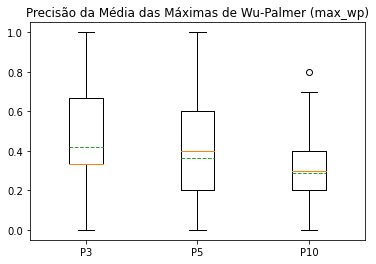

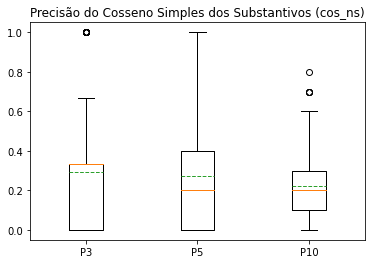

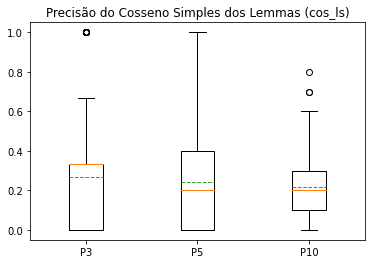

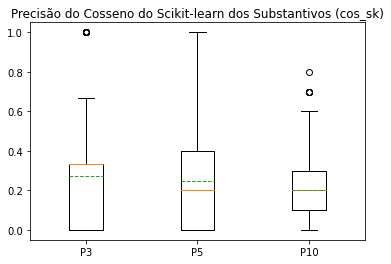

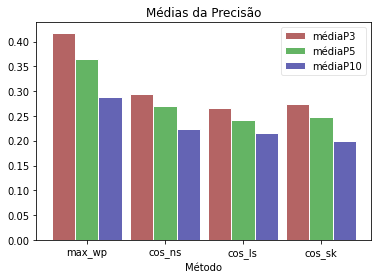

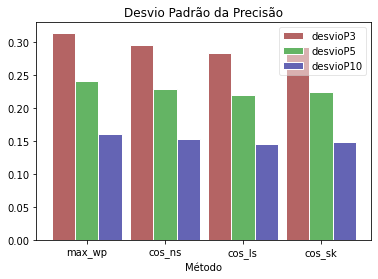

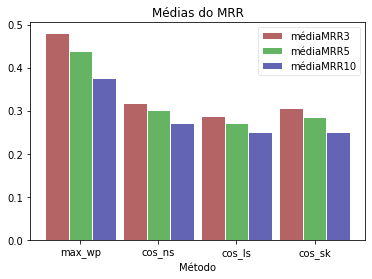

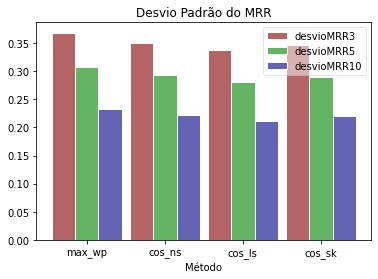

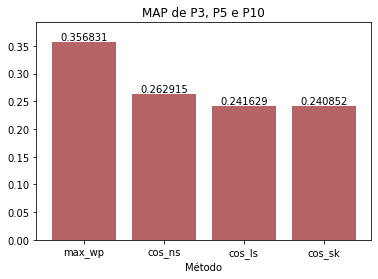

In [ ]:
colunas = ['analise','médiaP3','médiaP5','médiaP10','médiaMRR3','médiaMRR5','médiaMRR10']
colunas1 = ['analise','desvioP3','desvioP5','desvioP10','desvioMRR3','desvioMRR5','desvioMRR10']
linhas = ['max_wp','cos_ns','cos_ls','cos_sk']
url = "https://raw.githubusercontent.com/GabrielFCosta/preprocessamento/main/resultados.csv"
res = pd.read_csv(url)
res = res.drop(res.columns[[0, 1]],axis=1)
means = res.mean().tolist()
stds = res.std().tolist()
# cria dataframe de médias e desvios
first = 0
last = 6
lmean = []
lstd = []
medias = pd.DataFrame(columns = colunas)
desvios = pd.DataFrame(columns = colunas1)
for i in linhas:
  lmean = [i]
  lstd = [i]
  lmean.extend(means[first:last])
  lstd.extend(stds[first:last])
  medias = pd.concat([medias,pd.DataFrame([lmean],columns=colunas)])
  desvios = pd.concat([desvios,pd.DataFrame([lstd],columns=colunas1)])
  first += 6
  last += 6
# MAP de p3, p5 e p10
# medias das precisões de cada método por linha
max_wp = []
cos_ns = []
cos_ls = []
cos_sk = []
for i in range(res.shape[0]):
  max_wp.append(res.iloc[i][:3].mean())
  cos_ns.append(res.iloc[i][6:9].mean())
  cos_ls.append(res.iloc[i][12:15].mean())
  cos_sk.append(res.iloc[i][18:21].mean())
# MAP é a média das médias
maps = [stats.mean(max_wp),stats.mean(cos_ns),stats.mean(cos_ls),stats.mean(cos_sk)]

# gráfico do MAP
def simplebar(x,y,titulo,rotuloX):
  ax = plt.bar(x,y, color='#b46464')
  plt.title(titulo)
  plt.xlabel(rotuloX)
  plt.bar_label(ax, label_type='edge')
  plt.margins(y=0.1)
  plt.show()
# outros gráficos
def groupbarplot(bar1,bar2,bar3,labels,legends,titulo):
  #fig = plt.figure(figsize=(7,5))
  # largura das colunas
  largura = 0.30
  # dados são colunas do dataframe como listas
  # Set position of bar on X axis
  r1 = np.arange(len(bar1))
  r2 = [x + largura for x in r1]
  r3 = [x + largura for x in r2]
  # Make the plot
  plt.bar(r1, bar1, color='#b46464', width=largura, edgecolor='white', label=labels[0])
  plt.bar(r2, bar2, color='#64b464', width=largura, edgecolor='white', label=labels[1])
  plt.bar(r3, bar3, color='#6464b4', width=largura, edgecolor='white', label=labels[2])
  plt.xlabel('Método')
  plt.title(titulo)
   # Add xticks on the middle of the group bars
  plt.xticks([x + largura for x in range(len(bar1))],legends)
  # Create legend & Show graphic
  plt.legend(framealpha=0.5)
  plt.show()

def boxgraph(boxlist,titulo,rotulos):
  plt.title(titulo)
  plt.boxplot(boxlist,labels=rotulos,meanline=True, showmeans=True)
  plt.show()

boxgraph([res['max_wp_p3'],res['max_wp_p5'],res['max_wp_p10']],"Precisão da Média das Máximas de Wu-Palmer (max_wp)", ['P3','P5','P10'])
print('\n')
boxgraph([res['cos_ns_p3'],res['cos_ns_p5'],res['cos_ns_p10']],"Precisão do Cosseno Simples dos Substantivos (cos_ns)", ['P3','P5','P10'])
print('\n')
boxgraph([res['cos_ls_p3'],res['cos_ls_p5'],res['cos_ls_p10']],"Precisão do Cosseno Simples dos Lemmas (cos_ls)", ['P3','P5','P10'])
print('\n')
boxgraph([res['cos_sk_p3'],res['cos_sk_p5'],res['cos_sk_p10']],"Precisão do Cosseno do Scikit-learn dos Substantivos (cos_sk)", ['P3','P5','P10'])
print('\n')
groupbarplot(medias['médiaP3'].tolist(),medias['médiaP5'].tolist(),medias['médiaP10'].tolist(),
             list(medias.columns)[1:4],medias['analise'].tolist(),"Médias da Precisão")
print('\n')
groupbarplot(desvios['desvioP3'].tolist(),desvios['desvioP5'].tolist(),desvios['desvioP10'].tolist(),
             list(desvios.columns)[1:4],desvios['analise'].tolist(),"Desvio Padrão da Precisão")
print('\n')
groupbarplot(medias['médiaMRR3'].tolist(),medias['médiaMRR5'].tolist(),medias['médiaMRR10'].tolist(),
             list(medias.columns)[4:8],medias['analise'].tolist(),"Médias do MRR")
print('\n')
groupbarplot(desvios['desvioMRR3'].tolist(),desvios['desvioMRR5'].tolist(),desvios['desvioMRR10'].tolist(),
             list(desvios.columns)[4:8],desvios['analise'].tolist(),"Desvio Padrão do MRR")
print('\n')
simplebar(medias['analise'].tolist(),maps,"MAP de P3, P5 e P10","Método")
